<a href="https://colab.research.google.com/github/suchirmm/seoulbike/blob/main/project_seoulbike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Project Title : Seoul Bike Sharing Demand Prediction**





Problem Description
Currently Rental bikes are introduced in many urban cities for the enhancement of mobility comfort. It is important to make the rental bike available and accessible to the public at the right time as it lessens the waiting time. Eventually, providing the city with a stable supply of rental bikes becomes a major concern. The crucial part is the prediction of bike count required at each hour for the stable supply of rental bikes.

## <b> Data Description </b>

### <b> The dataset contains weather information (Temperature, Humidity, Windspeed, Visibility, Dewpoint, Solar radiation, Snowfall, Rainfall), the number of bikes rented per hour and date information.</b>


### <b>Attribute Information: </b>

* ### Date : year-month-day
* ### Rented Bike count - Count of bikes rented at each hour
* ### Hour - Hour of he day
* ### Temperature-Temperature in Celsius
* ### Humidity - %
* ### Windspeed - m/s
* ### Visibility - 10m
* ### Dew point temperature - Celsius
* ### Solar radiation - MJ/m2
* ### Rainfall - mm
* ### Snowfall - cm
* ### Seasons - Winter, Spring, Summer, Autumn
* ### Holiday - Holiday/No holiday
* ### Functional Day - NoFunc(Non Functional Hours), Fun(Functional hours)

## **Read data**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import chardet


from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, \
GridSearchCV

from sklearn.metrics import classification_report, confusion_matrix, \
accuracy_score, auc, precision_score, recall_score, r2_score

from sklearn.feature_selection import mutual_info_classif

from sklearn.inspection import permutation_importance

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
pd.set_option('max_rows', None)
pd.set_option('max_columns', None)

In [ ]:
link = '/content/drive/MyDrive/SeoulBikeData.csv'

with open(link, 'rb') as file:
    print(chardet.detect(file.read()))

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


In [ ]:
data = pd.read_csv(link, encoding = 'ISO-8859-1')
data.head()



,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


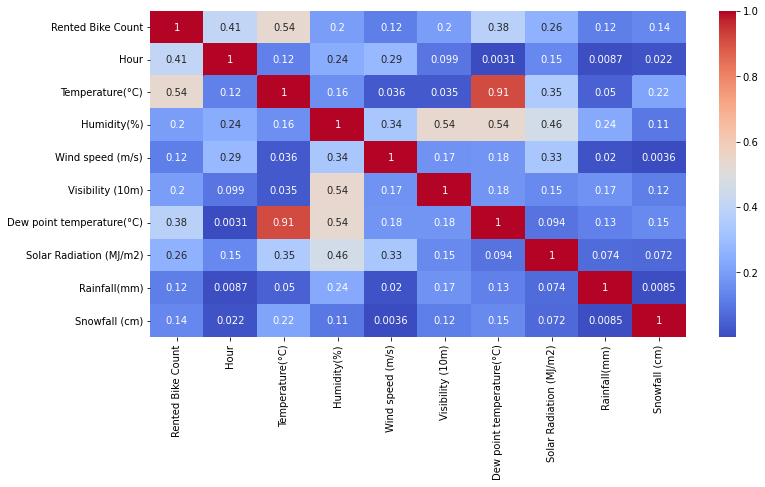

In [ ]:
plt.figure(figsize = (12,6))
correlation = data.corr()
sns.heatmap(abs(correlation), annot = True, cmap = 'coolwarm')

plt.show()

In [ ]:
data.shape

(8760, 14)

In [ ]:
# No null values
# Hence no missing value cleaning is required

print ('Total null : {}\n'.format(data.isnull().sum().sum()))
data.isnull().sum()

Total null : 0



Date                         0
Rented Bike Count            0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
dtype: int64

In [ ]:
# data['Date'].dtype should not be object

data.dtypes

Date                          object
Rented Bike Count              int64
Hour                           int64
Temperature(°C)              float64
Humidity(%)                    int64
Wind speed (m/s)             float64
Visibility (10m)               int64
Dew point temperature(°C)    float64
Solar Radiation (MJ/m2)      float64
Rainfall(mm)                 float64
Snowfall (cm)                float64
Seasons                       object
Holiday                       object
Functioning Day               object
dtype: object

In [ ]:
# See number of unique values
# Number of days - Shows one year data
# Seasons - 4 (typical)
# Rest of data is bool type

for x in data.describe(include = 'object').columns:
  print ("{} :  {} ". format(x, data[x].nunique()))

Date :  365 
Seasons :  4 
Holiday :  2 
Functioning Day :  2 


In [ ]:
# Checking whether there are any duplicates
# 0 duplicates

len(data[data.duplicated()])

0

## **Data Cleaning**

In [ ]:
# make a copy of the data

df = data.copy()
df.head(3)

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes


In [ ]:
#change the name of the columns

df.columns = df.columns.str.replace(' ', '_')
df.columns = df.columns.str.lower()

# str.title() creates problems
# df.columns = df.columns.str.title()

In [ ]:
# some of the column names are strange
# visibility_(10m) , snowfall_(cm)

df.head(3)

,date,rented_bike_count,hour,temperature(°c),humidity(%),wind_speed_(m/s),visibility_(10m),dew_point_temperature(°c),solar_radiation_(mj/m2),rainfall(mm),snowfall_(cm),seasons,holiday,functioning_day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes


In [ ]:
# To change the string titles

def edit_string(txt):

  x = txt.find("(") -1
  if txt[x] == "_":
    hext = txt[0:x] + txt[x+1:]
    return hext
  
  else:
    return txt

def edit_string_temperature(txt):

  if 'temperature' in txt and '(' in txt and ')' in  txt :
    x = txt.find("(")
    txt = txt[:x]

    return txt


lstm = []
for x in df.columns:
  lstm.append(edit_string(x))

df.columns = lstm

lstm = []

del(lstm)

index = []
for x in df.columns:
  if 'temperature' in x:
    index.append(df.columns.get_loc(x))

index

for x in index:
  df.rename(columns = {df.columns[x] : edit_string_temperature(df.columns[x])} ,inplace = True)

df.head(3)

,date,rented_bike_count,hour,temperature,humidity(%),wind_speed(m/s),visibility(10m),dew_point_temperature,solar_radiation(mj/m2),rainfall(mm),snowfall(cm),seasons,holiday,functioning_day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes


In [ ]:
# Transform feature - date
# date is object dtype and not date dtype

df.dtypes

date                       object
rented_bike_count           int64
hour                        int64
temperature               float64
humidity(%)                 int64
wind_speed(m/s)           float64
visibility(10m)             int64
dew_point_temperature     float64
solar_radiation(mj/m2)    float64
rainfall(mm)              float64
snowfall(cm)              float64
seasons                    object
holiday                    object
functioning_day            object
dtype: object

In [ ]:
# date - Yearly data
# seasons - typical
# holiday, functioing_day - bool

for x in df.describe(include = 'object').columns:
  print ("{} : {}" .format(x ,df[x].nunique()))

date : 365
seasons : 4
holiday : 2
functioning_day : 2


In [ ]:
# No need for a year column
# Its all in one month 

df['date'] = pd.to_datetime(df['date'], format="%d/%m/%Y")

df.insert(loc= 1, column = 'day_num', value = df['date'].dt.day)
df.insert(loc= 2, column = 'month', value = df['date'].dt.month)


In [ ]:
df.head(3)

,date,day_num,month,rented_bike_count,hour,temperature,humidity(%),wind_speed(m/s),visibility(10m),dew_point_temperature,solar_radiation(mj/m2),rainfall(mm),snowfall(cm),seasons,holiday,functioning_day
0,2017-12-01,1,12,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,2017-12-01,1,12,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2017-12-01,1,12,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes


In [ ]:
# To check if errors have crept in when changing date
# Seems to be none

df.isnull().sum()

date                      0
day_num                   0
month                     0
rented_bike_count         0
hour                      0
temperature               0
humidity(%)               0
wind_speed(m/s)           0
visibility(10m)           0
dew_point_temperature     0
solar_radiation(mj/m2)    0
rainfall(mm)              0
snowfall(cm)              0
seasons                   0
holiday                   0
functioning_day           0
dtype: int64

In [ ]:
target_variable = 'rented_bike_count'
categorical_features  = df.describe(include = 'object').columns.tolist()
numerical_features = df.describe().columns.tolist()
numerical_features.remove(target_variable)

In [ ]:
categorical_features

['seasons', 'holiday', 'functioning_day']

In [ ]:
numerical_features

['day_num',
 'month',
 'hour',
 'temperature',
 'humidity(%)',
 'wind_speed(m/s)',
 'visibility(10m)',
 'dew_point_temperature',
 'solar_radiation(mj/m2)',
 'rainfall(mm)',
 'snowfall(cm)']

In [ ]:
# Getting data by date
# Aggregating data over unique date
# Dataset is hourly otherwise

df_dates =  \
    df[['date', 'temperature','humidity(%)', 'wind_speed(m/s)' ,
      'dew_point_temperature',  'solar_radiation(mj/m2)', 'rainfall(mm)' ,
      'snowfall(cm)', 'rented_bike_count']]\
    .groupby('date')\
    .agg({'temperature' : 'median', 'humidity(%)' : 'median', 
          'wind_speed(m/s)' : 'median', 'dew_point_temperature' : 'median', 
          'solar_radiation(mj/m2)' : 'sum', 'rainfall(mm)' : 'sum', 
          'snowfall(cm)' : 'sum', 'rented_bike_count' : 'sum'})
    
df_dates

list_seasons = []
list_holiday = []
list_functioning_day = []

for x in df['date'].unique():

  list_seasons.append(df[df['date'] == x ]['seasons'].mode()[0])
  list_holiday.append(df[df['date'] == x ]['holiday'].mode()[0])
  list_functioning_day.append(df[df['date'] == x ]['functioning_day'].mode()[0])



df_dates.insert(loc = len(df_dates.columns), column = 'seasons', value = list_seasons)
df_dates.insert(loc = len(df_dates.columns), column = 'holiday', value = list_holiday)
df_dates.insert(loc = len(df_dates.columns), column = 'functioning_day', value = list_functioning_day)

df_dates.head()

,temperature,humidity(%),wind_speed(m/s),dew_point_temperature,solar_radiation(mj/m2),rainfall(mm),snowfall(cm),rented_bike_count,seasons,holiday,functioning_day
date,,,,,,,,,,,
2017-12-01,-1.10,37.5,1.4,-17.40,5.97,0.0,0.0,9539,Winter,No Holiday,Yes
2017-12-02,2.70,55.5,1.6,-5.55,6.33,0.0,0.0,8523,Winter,No Holiday,Yes
2017-12-03,4.35,84.5,1.6,2.65,3.01,4.0,0.0,7222,Winter,No Holiday,Yes
2017-12-04,-0.25,43.5,3.6,-12.95,6.79,0.1,0.0,8729,Winter,No Holiday,Yes
2017-12-05,-3.80,34.5,0.0,-17.70,0.86,0.0,0.0,8307,Winter,No Holiday,Yes


## **Sanity Check**

In [ ]:
# No snowfall in summer 
# Seems logical

df_dates[df_dates['seasons'] == 'Summer']['snowfall(cm)'].max()



0.0

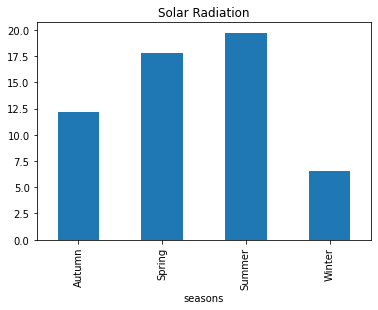

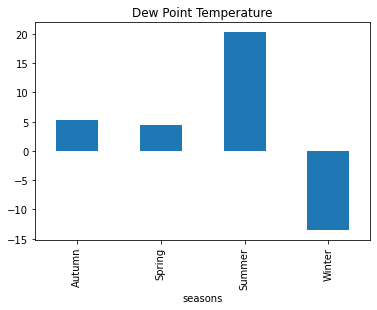

In [ ]:
# The seasonal vairation of solar radiation seems logical

plt.figure()
plt.title('Solar Radiation')
df_dates.groupby('seasons')['solar_radiation(mj/m2)'].median().plot.bar()
plt.show()

# print("\n", df_dates[['seasons', 'solar_radiation(mj/m2)']].groupby('seasons').median(), "\n")

# The seasonal vairation of dew point temperature seems logical

plt.figure()
plt.title('Dew Point Temperature')
df_dates.groupby('seasons')['dew_point_temperature'].median().plot.bar()
plt.show()

# df_dates[['seasons', 'dew_point_temperature']].groupby('seasons').median()

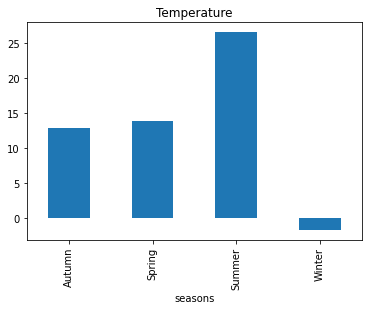

In [ ]:
# Seasonal temperature variation seems logical

plt.figure()
plt.title('Temperature')
df_dates.groupby('seasons')['temperature'].median().plot.bar()
plt.show()

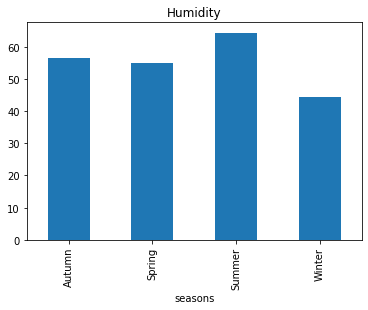

In [ ]:
# Humidity variation seems somewhat logical
# No real pattern

plt.figure()
plt.title('Humidity')
df_dates.groupby('seasons')['humidity(%)'].median().plot.bar()
plt.show()

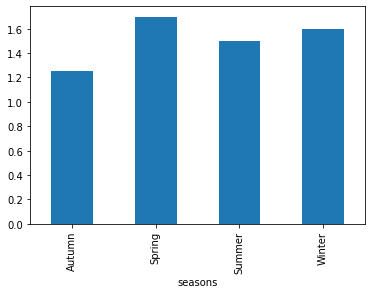

In [ ]:
# Nothing to infer from this 
# No idea how wind speeds corresponds to seasons

df_dates.groupby('seasons')['wind_speed(m/s)'].median().plot.bar()

seasons  holiday   
Autumn   No Holiday    86
         Holiday        5
Spring   No Holiday    89
         Holiday        3
Summer   No Holiday    90
         Holiday        2
Winter   No Holiday    82
         Holiday        8
Name: holiday, dtype: int64


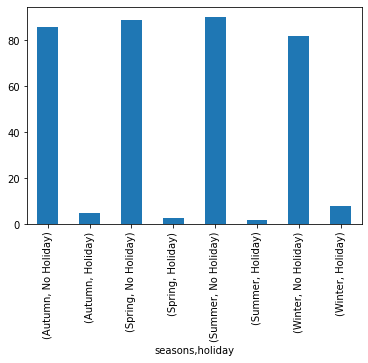

In [ ]:
# Quite the way more insightful than i thought it would
# Korea doesnt seems to have very many holidays
# Winter may have more holidays because of excess snow ??


print(df_dates.groupby('seasons')['holiday'].value_counts())

df_dates.groupby('seasons')['holiday'].value_counts().plot.bar()


In [ ]:
# Conclusion - Sanity check passed
# The data follows the logic of weather 
# High confidence

## **Exploration & Visualisation**

### **Categorical Features**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


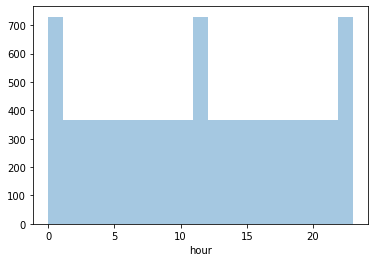

In [ ]:
# Most natural phenomena should be normally distributed
# Normal - Humidity(%), Temperature( C)
# Normal w/skew - Wind speed (m/s),  Dew point temperature(C)

# Skewed - Visibility (10m), Solar Radiation (MJ/m2) , Rainfall(mm) , Snowfall (cm)                


sns.distplot(a = df['hour'], kde = False)

<Figure size 432x288 with 0 Axes>

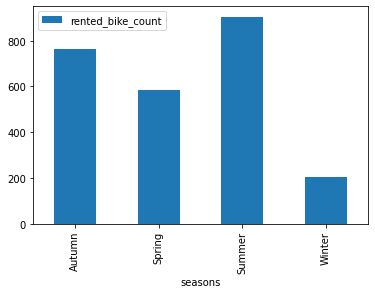

,rented_bike_count
seasons,
Autumn,763.5
Spring,583.0
Summer,905.5
Winter,203.0


In [ ]:
# Rented bikes by season
# Winter has the least
# Less cycling it seems

plt.figure()
df[['seasons', 'rented_bike_count']].groupby('seasons').median().plot.bar()
plt.show()

df[['seasons', 'rented_bike_count']].groupby('seasons').median()

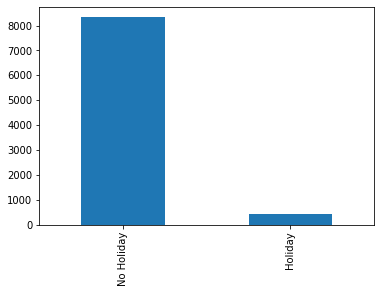

In [ ]:
# Value counts for df['holiday']
# Will probably have to be dropped

df['holiday'].value_counts().plot(kind = 'bar')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


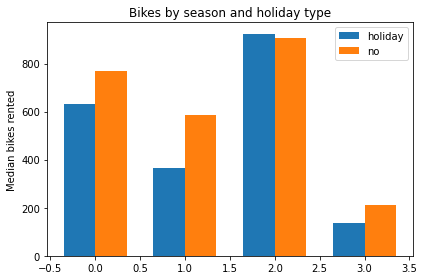

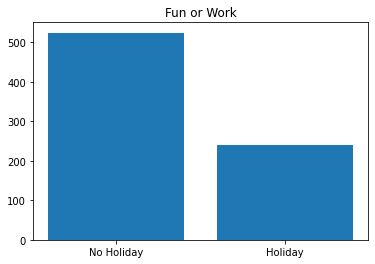

,rented_bike_count
holiday,
Holiday,240.0
No Holiday,524.5


In [ ]:
# df[holiday] has two possibilites - Holiday or Not Holiday
# It seems bikes are rented more on Working Day (No Holiday)
# df[holiday] is a pertinent feature with predictive power

df.loc[df['holiday'] == 'Holiday'].groupby('seasons')['rented_bike_count'].median().tolist()

df.loc[df['holiday'] == 'No Holiday'].groupby('seasons')['rented_bike_count'].median().tolist()

labels = df.loc[df['holiday'] == 'Holiday'].groupby('seasons')['rented_bike_count'].median().index.tolist()

holiday = df.loc[df['holiday'] == 'Holiday'].groupby('seasons')['rented_bike_count'].median().tolist()
no_holiday = df.loc[df['holiday'] == 'No Holiday'].groupby('seasons')['rented_bike_count'].median().tolist()


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, holiday, width, label='holiday')
rects2 = ax.bar(x + width/2, no_holiday, width, label='no')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Median bikes rented')
ax.set_title('Bikes by season and holiday type')
ax.set_xticks(x, labels)
ax.legend()

# ax.bar_label(rects1)
# ax.bar_label(rects2)

fig.tight_layout()


plt.show()

# Checking num of rented bikes by holiday or NO holiday

plt.title('Fun or Work')
plt.bar(['No Holiday', 'Holiday'], [df.loc[df['holiday'] == 'No Holiday', ['rented_bike_count']]['rented_bike_count'].median(),\
                                    df.loc[df['holiday'] == 'Holiday', ['rented_bike_count']]['rented_bike_count'].median()])
plt.show()

df[['holiday', 'rented_bike_count']].groupby('holiday')\
.agg({'rented_bike_count' : 'median'})

functioning_day
No       0.0
Yes    542.0
Name: rented_bike_count, dtype: float64

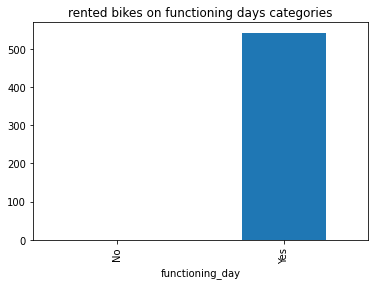

In [ ]:
# Functioning day means the company is functioning
# So no rentals on that day of course 
# functioning has predictive power

# df.groupby('functioning_day')['rented_bike_count'].max()

df.groupby('functioning_day')['rented_bike_count'].median().plot(
    kind = 'bar', title = 'rented bikes on functioning days categories')

df.groupby('functioning_day')['rented_bike_count'].median()

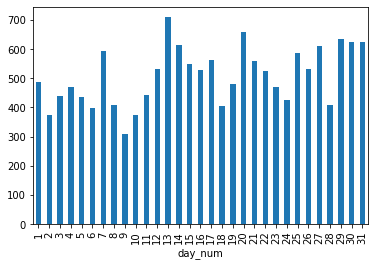

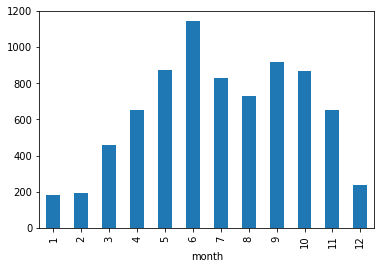

In [ ]:
# Check df[day_num] and df[month]
# Analysis of month and day_num
# day_num doesnt have a patttern
# df[month] corresponds to what we saw in seasons

plt.figure()
df[['rented_bike_count','day_num']].groupby('day_num')['rented_bike_count'].median().plot.bar()
plt.show()

plt.figure()
df[['rented_bike_count','month']].groupby('month')['rented_bike_count'].median().plot.bar()
plt.show()

In [ ]:
df_dates[df_dates['seasons'] == 'Winter']

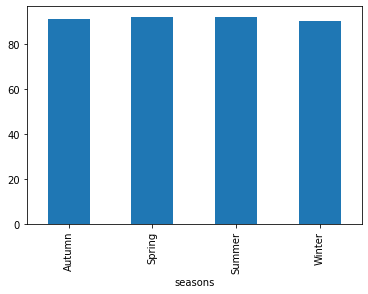

,min_snow,min_rain,min_temp,max_snow,max_rain,max_temp,median_snow,median_rain,median_temp,mean_snow,mean_rain,mean_temp
seasons,,,,,,,,,,,,
Autumn,0.0,0.0,2.00,78.7,56.5,25.55,0.0,0.0,12.850,1.351648,2.946154,13.855495
Spring,0.0,0.0,0.20,0.0,82.5,24.80,0.0,0.0,13.850,0.000000,4.389130,12.932609
Summer,0.0,0.0,19.80,0.0,95.5,33.10,0.0,0.0,26.525,0.000000,6.083696,26.190761
Winter,0.0,0.0,-14.85,64.8,23.0,5.65,0.0,0.0,-1.725,5.940000,0.787778,-2.438889


In [ ]:
# This is not so easy to read 
# All the temp, snowfall, rainfall should be closely placed

df1 = df_dates[['snowfall(cm)', 'temperature', 'rainfall(mm)', 'seasons']]\
.groupby('seasons')\
.agg({'snowfall(cm)' : 'min', 'rainfall(mm)' : 'min', 'temperature' : 'min'})\
.rename(columns = {'snowfall(cm)' : 'min_snow',
                   'rainfall(mm)' : 'min_rain',
                   'temperature' : 'min_temp'})


df2 = df_dates[['snowfall(cm)', 'temperature', 'rainfall(mm)', 'seasons']]\
.groupby('seasons')\
.agg({'snowfall(cm)' : 'max', 'rainfall(mm)' : 'max', 'temperature' : 'max'})\
.rename(columns = {'snowfall(cm)' : 'max_snow',
                   'rainfall(mm)' : 'max_rain',
                   'temperature' : 'max_temp'})

df3 = df_dates[['snowfall(cm)', 'temperature', 'rainfall(mm)', 'seasons']]\
.groupby('seasons')\
.agg({'snowfall(cm)' : 'median', 'rainfall(mm)' : 'median', 'temperature' : 'median'})\
.rename(columns = {'snowfall(cm)' : 'median_snow',
                   'rainfall(mm)' : 'median_rain',
                   'temperature' : 'median_temp'})

df4 = df_dates[['snowfall(cm)', 'temperature', 'rainfall(mm)', 'seasons']]\
.groupby('seasons')\
.agg({'snowfall(cm)' : 'mean', 'rainfall(mm)' : 'mean', 'temperature' : 'mean'})\
.rename(columns = {'snowfall(cm)' : 'mean_snow',
                   'rainfall(mm)' : 'mean_rain',
                   'temperature' : 'mean_temp'})


plt.figure()
df_dates.groupby('seasons')['holiday'].count().plot.bar()
plt.show()

pd.concat([df1, df2, df3, df4],axis=1)

In [ ]:
del(df1)
del(df2)
del(df3)
del(df4)

In [ ]:
df_dates.head()

,temperature,humidity(%),wind_speed(m/s),dew_point_temperature,solar_radiation(mj/m2),rainfall(mm),snowfall(cm),rented_bike_count,seasons,holiday,functioning_day
date,,,,,,,,,,,
2017-12-01,-1.10,37.5,1.4,-17.40,5.97,0.0,0.0,9539,Winter,No Holiday,Yes
2017-12-02,2.70,55.5,1.6,-5.55,6.33,0.0,0.0,8523,Winter,No Holiday,Yes
2017-12-03,4.35,84.5,1.6,2.65,3.01,4.0,0.0,7222,Winter,No Holiday,Yes
2017-12-04,-0.25,43.5,3.6,-12.95,6.79,0.1,0.0,8729,Winter,No Holiday,Yes
2017-12-05,-3.80,34.5,0.0,-17.70,0.86,0.0,0.0,8307,Winter,No Holiday,Yes


### **Numerical features**

In [ ]:
df.head()

In [ ]:
numerical_features

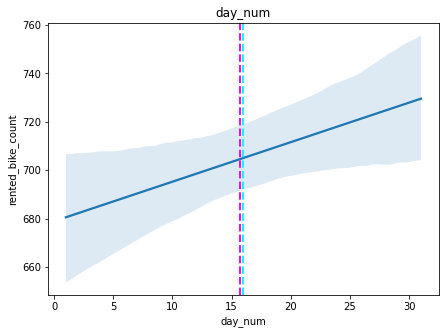

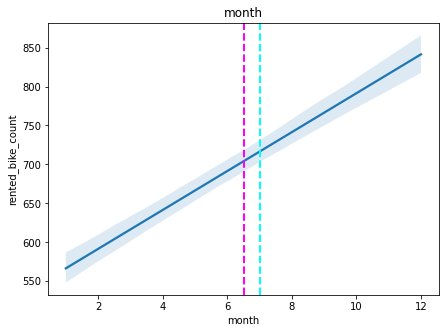

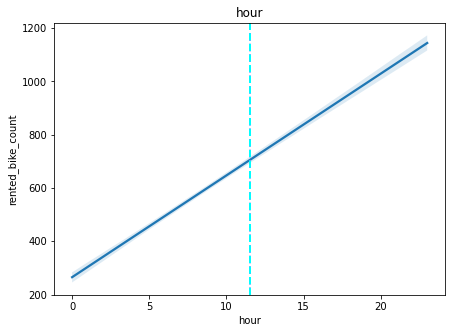

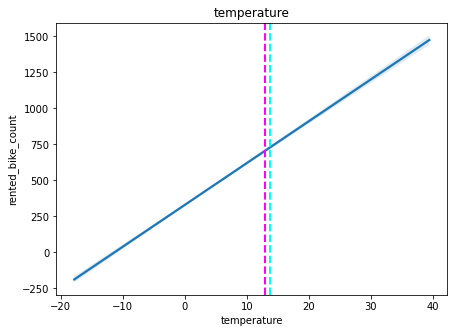

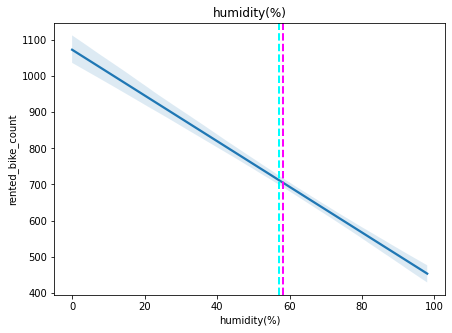

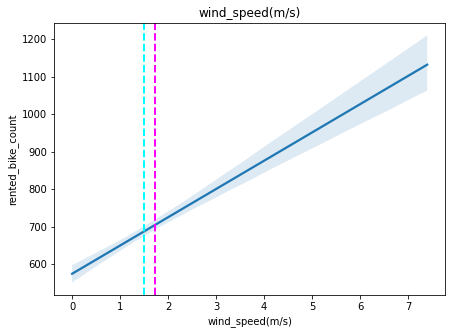

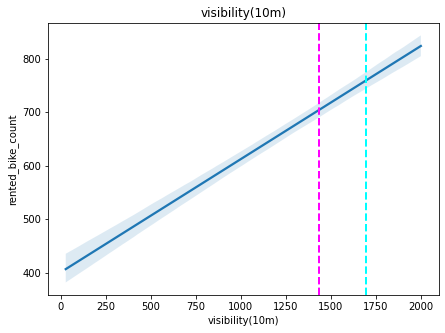

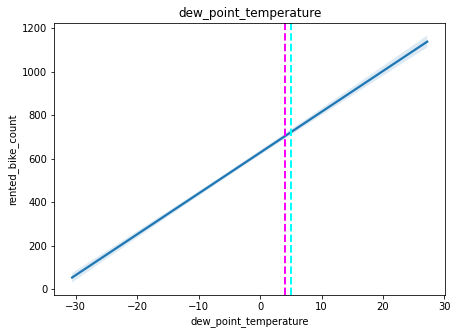

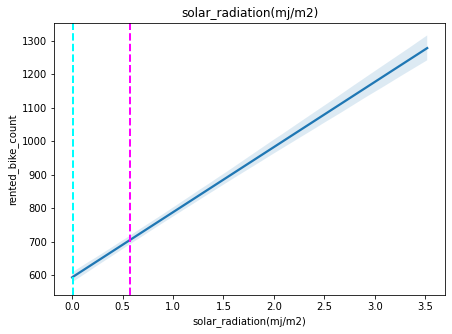

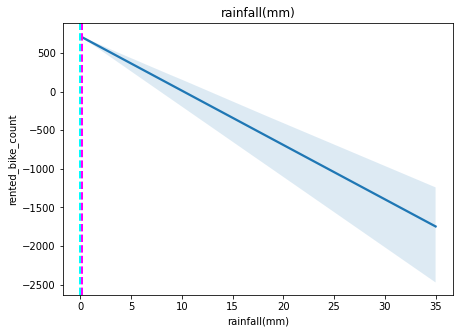

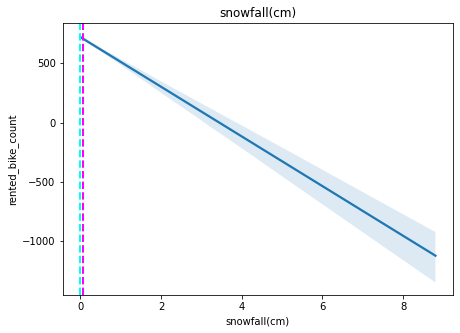

In [ ]:
# hour : +ve correlated  (This will be periodic)
# temperature : + ve correlated 
# humidity : moderately -ve correlated 
# windspeed : moderately +ve correlated

# visibility(10m): moderately +ve correlated
# dew_point_temperature - +ve correlated
# rainfall(mm) : -ve correlated
# snowfall(cm) : -ve correlated


for col in numerical_features:
    fig = plt.figure(figsize=(7,5))
    ax = fig.gca()
    feature = df[col]
    sns.regplot(x=feature, y=df['rented_bike_count'], scatter = False)
    # feature.hist(bins=50, ax = ax)
    ax.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
    ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)    
    ax.set_title(col)
plt.show()

In [ ]:
numerical_features

In [ ]:
df.head(2)

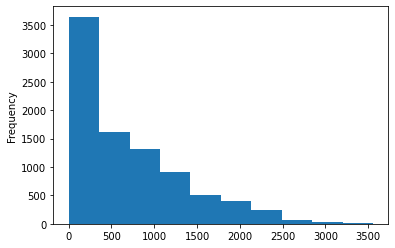

In [ ]:
# How can this feature impact 
# Its important that dev and test set are the same
# In real world the test set 

df['rented_bike_count'].plot(kind = 'hist')

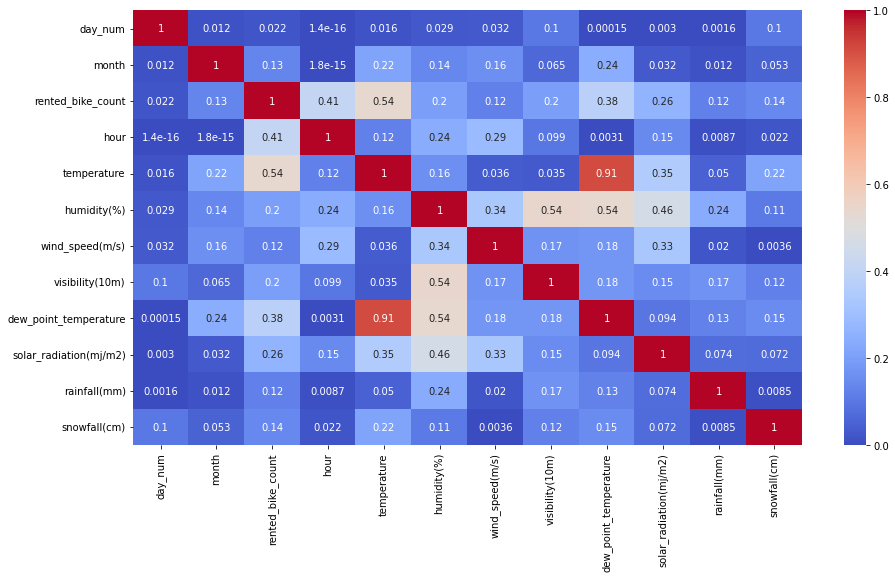

In [ ]:
plt.figure(figsize=(15,8))
correlation = df.corr()
sns.heatmap(abs(correlation), annot=True, cmap='coolwarm')

In [ ]:
'''
fig,ax = plt.subplots(3,3,figsize=(15,10))
row = col = 0
for n,i in enumerate(numeric_features):
    if (n%3 == 0) & (n > 0):
        row += 1
        col = 0
    sns.regplot(x=i,y="target",data=data,ax=ax[row,col],ci=False)
    col += 1

num_tgt = numeric_features.copy() 
num_tgt.append('target')
fig = plt.figure(figsize=(8,8))
sns.heatmap(data[num_tgt].corr(method='pearson'),annot=True,fmt='.2f',mask=np.triu(data[num_tgt].corr(method='pearson')),cbar=False)

fig = plt.figure(figsize=(8,8))
sns.heatmap(data[num_tgt].corr(method='kendall'),annot=True,fmt='.2f',mask=np.triu(data[num_tgt].corr(method='pearson')),cbar=False)

fig = plt.figure(figsize=(8,8))
sns.heatmap(data[num_tgt].corr(method='kendall'),annot=True,fmt='.2f',mask=np.triu(data[num_tgt].corr(method='pearson')),cbar=False)

'''

## **Outlier - Detection and Removal**

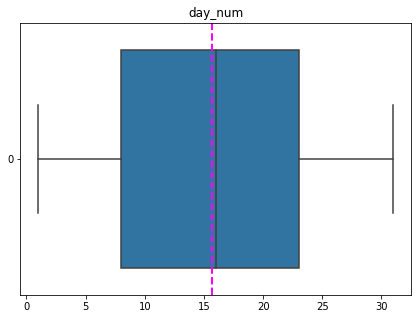

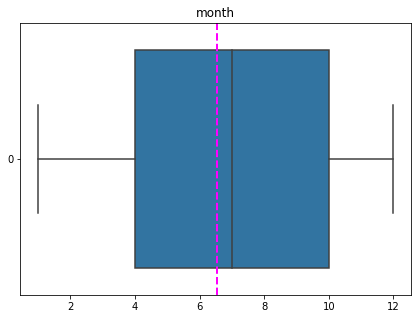

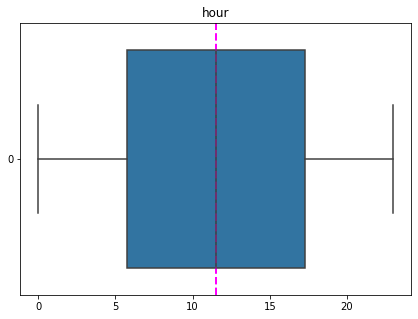

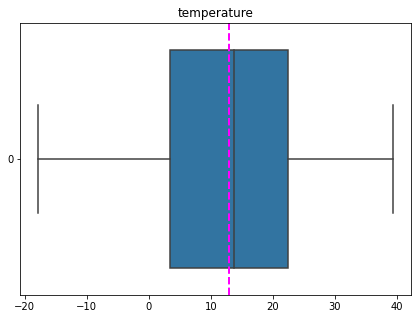

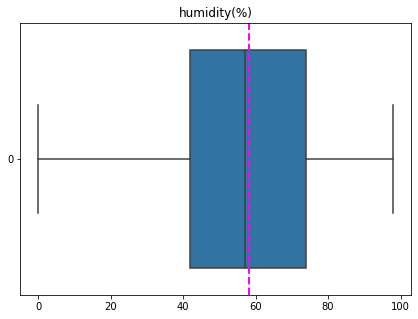

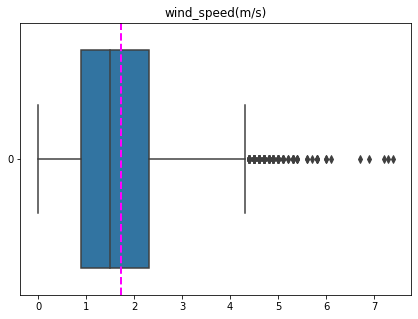

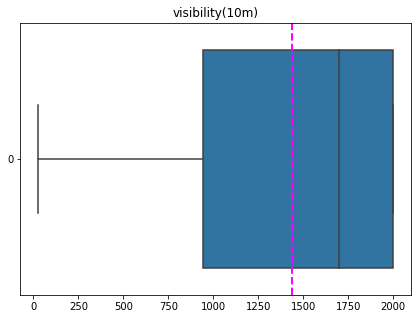

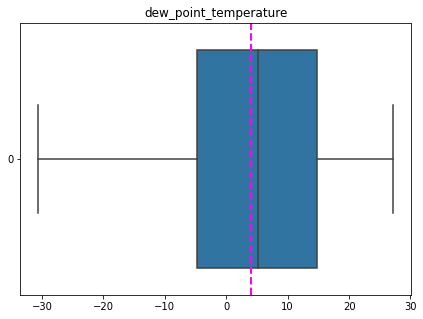

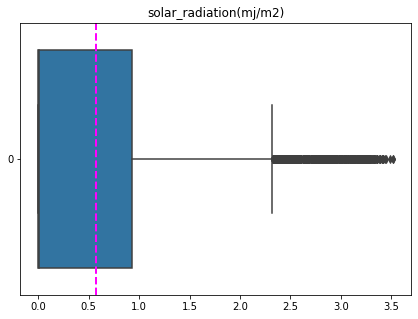

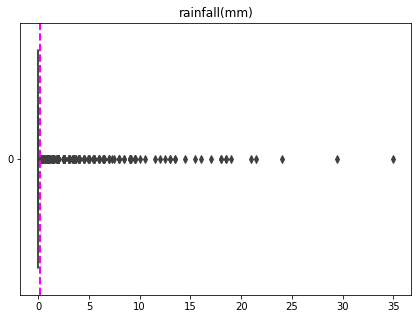

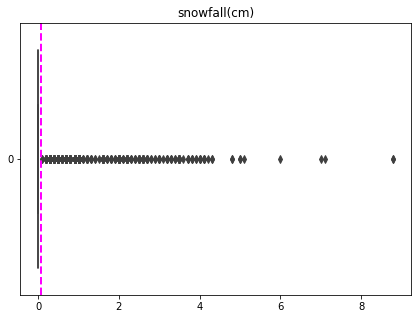

In [ ]:
# Checking for outliers
# Outliers - Windspeed, solar_radiation(mj/m2), rainfall(mm), snowfall(cm)

for col in numerical_features:
    fig = plt.figure(figsize=(7,5))
    ax = fig.gca()
    feature = df[col]
    sns.boxplot(data = feature, orient = 'h')
    # feature.hist(bins=50, ax = ax)
    ax.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
    # ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)    
    ax.set_title(col)
plt.show()

## **Feature Importance**

In [ ]:
categorical_features

['seasons', 'holiday', 'functioning_day']

Feature: 0, Score: 0.0
Feature: 1, Score: 0.0018780315637629205
Feature: 2, Score: 0.006220233832105228
Feature: 3, Score: 0.006256299088401021
Feature: 4, Score: 0.007317922395824973
Feature: 5, Score: 0.007884965726281227
Feature: 6, Score: 0.009698459599393815
Feature: 7, Score: 0.01000020055863719
Feature: 8, Score: 0.011628652063517672
Feature: 9, Score: 0.03262874953954849
Feature: 10, Score: 0.04619740589248457
Feature: 11, Score: 0.06510209205881008
Feature: 12, Score: 0.08611677982016257
Feature: 13, Score: 0.10409196976541245
Feature: 14, Score: 0.11407804816732768
Feature: 15, Score: 0.11583335751582576
Feature: 16, Score: 0.12221680275418856
Feature: 17, Score: 0.1262859980358719
Feature: 18, Score: 0.1265640316224439

 



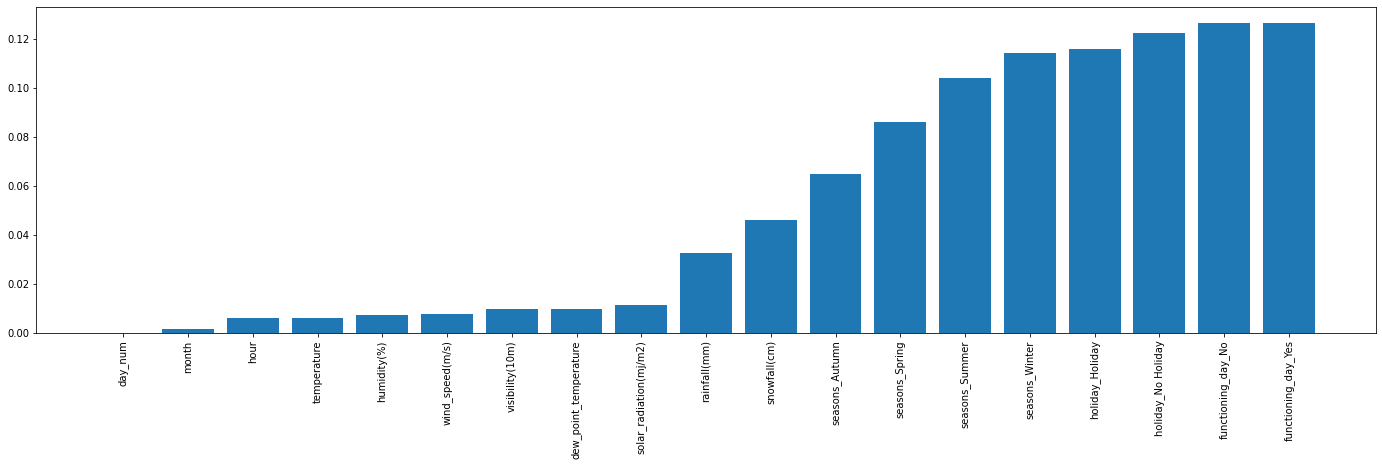

In [ ]:
from sklearn.tree import DecisionTreeClassifier

X  = df.iloc[:, 1:].copy()
X = pd.get_dummies(X, columns=categorical_features, prefix=["seasons", "holiday", "functioning_day"])

y = X.pop(target_variable)


model = DecisionTreeClassifier()
# fit the model
model.fit(X, y)


# get importance
importance = model.feature_importances_
importance=np.sort(importance)

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: {}, Score: {}'.format(i, v))

print ("\n \n")


# plot feature importance
plt.figure(figsize = (24,6))
plt.xticks(rotation ='vertical')
plt.bar([X.columns[x] for x in range(len(importance))], importance)
plt.show()

### **Mutual Information**

In [ ]:
model.feature_importances_

array([0.10375925, 0.04765536, 0.08681871, 0.13148504, 0.11532005,
       0.1234157 , 0.1146312 , 0.11831711, 0.06798872, 0.00893509,
       0.00848286, 0.00825043, 0.01050966, 0.00797319, 0.00166427,
       0.00644612, 0.00571849, 0.        , 0.03262875])

In [ ]:
X.columns[5]

'wind_speed(m/s)'

In [ ]:
X.head()

In [ ]:
target_variable

In [ ]:
X = df.iloc[:, 1:].copy()
y = X.pop(target_variable)


In [ ]:
# Factorizing the columns

for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

X = X.astype(int)
X.head()
# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes

In [ ]:
X.dtypes

In [ ]:
def plot_mi_scores(scores):

    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")



In [ ]:
X.dtypes

In [ ]:
'''

from sklearn.feature_selection import mutual_info_classif


def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show a few features with their MI scores
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

'''

## **Model**

In [ ]:
X = df.copy()

In [ ]:
X = X.drop(['date'], axis = 1)
X.shape

(8760, 15)

In [ ]:
y = X.pop(target_variable)

In [ ]:
X = pd.get_dummies(X, columns=categorical_features, prefix=["seasons", "holiday", "functioning_day"])

In [ ]:
rf_regressor = RandomForestRegressor()

In [ ]:
from sklearn.model_selection import cross_validate

cross_val = cross_validate(rf_regressor, X,y, cv = 5, scoring = 'r2')
cross_val

{'fit_time': array([4.03702188, 3.86262107, 3.83928728, 3.85239792, 3.9214375 ]),
 'score_time': array([0.03464723, 0.04023337, 0.04093266, 0.0373559 , 0.04193163]),
 'test_score': array([-2.24756914,  0.53464935,  0.75062159,  0.60157868,  0.68569799])}

In [ ]:
# You can see the difference in the 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Decision Tree model creation
rf_regressor = DecisionTreeRegressor()
rf_regressor.fit(X_train, y_train)

# predictions
rf_predict = dt_regressor.predict(X_test)
rd_train_predict = dt_regressor.predict(X_train)

# Evaluation metrics
# Model has been fit well to the data

print('Training set metrics:')
print('Accuracy:', r2_score(y_train, rf_regressor.predict(X_train)))
# print('Precision:', precision_score(y_train, dt_regressor.predict(X_train)))
# print('Recall:', recall_score(y_train, dt_regressor.predict(X_train)))

print('Test set metrics:')
print('Accuracy:', r2_score(y_test, rf_regressor.predict(X_test)))
# print('Precision:', precision_score(y_test, dt_regressor.predict(X_test)))
# print('Recall:', recall_score(y_test, dt_regressor.predict(X_test)))

Training set metrics:
Accuracy: 1.0
Test set metrics:
Accuracy: 0.7657072276838566


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
# Decision Tree model creation
dt_regressor = DecisionTreeRegressor(max_depth = 10, random_state=37)
dt_regressor.fit(X_train, y_train)

# predictions
dt_predict = dt_regressor.predict(X_test)
dt_train_predict = dt_regressor.predict(X_train)

In [ ]:
# Evaluation metrics
# Model has been fit well to the data

print('Training set metrics:')
print('Accuracy:', r2_score(y_train, dt_regressor.predict(X_train)))
# print('Precision:', precision_score(y_train, dt_regressor.predict(X_train)))
# print('Recall:', recall_score(y_train, dt_regressor.predict(X_train)))

print('Test set metrics:')
print('Accuracy:', r2_score(y_test, dt_regressor.predict(X_test)))
# print('Precision:', precision_score(y_test, dt_regressor.predict(X_test)))
# print('Recall:', recall_score(y_test, dt_regressor.predict(X_test)))

Training set metrics:
Accuracy: 0.8941458213979059
Test set metrics:
Accuracy: 0.8106716963350953


In [ ]:
from sklearn import tree

graph = Source(tree.export_graphviz(dt_regressor, out_file=None
   , feature_names=X_train.columns
   , filled = True))
display(SVG(graph.pipe(format='svg')))


NameError: ignored

### **Random Search CV**

In [ ]:
# n_estimators = [int(x) for x in np.linspace(start = 5, stop = 50, num = 25)]

# number of features at every split
max_features = ['auto', 'sqrt', 'log2']

# max depth
max_depth = [int(x) for x in np.linspace(10, 100 , num = 10)]
max_depth.append(None)

max_leaf_nodes = [int(x) for x in np.linspace(10, 35, num = 10)]
max_leaf_nodes.append(None)

min_leaf_samples = [int(x) for x in np.linspace(5, 100, num = 10)]
min_leaf_samples.append(None)


# create random grid
random_grid = {
 'max_features': max_features,
 'max_depth': max_depth,
 'max_leaf_nodes' : max_leaf_nodes,
 'min_samples_leaf' :  min_leaf_samples,
 'min_impurity_decrease' : [0.05, 0.1, 0.15 , 0.2]
 }
 
 # Random search of parameters
dt_regressor = DecisionTreeRegressor(criterion = 'squared_error', random_state=37)
dt_random_cv = RandomSearchCV(estimator = dt_regressor, param_grid = random_grid, n_iter = 1000, cv = 5, verbose=4, n_jobs = -1)

# Fit the model
dt_random_cv.fit(X_train, y_train)

# print results
print(dt_random_cv.best_params_)

In [ ]:
r2_score(y_test, dt_random_cv.predict_proba(X_test))

In [ ]:
print(dt_random_cv.best_params_)

In [ ]:
dt_regressor = DecisionTreeRegressor(criterion = 'squared_error',
                                     max_leaf_nodes = None,
                                     max_features = 'auto',
                                     max_depth = 20,
                                     min_samples_leaf = 15,
                                     min_impurity_decrease = 0.05,
                                     random_state= 42)

dt_regressor.fit(X_train, y_train)


print('Training set metrics:')
print('Accuracy:', r2_score(y_train, dt_regressor.predict(X_train)))


print('Test set metrics:')
print('Accuracy:', r2_score(y_test, dt_regressor.predict(X_test)))


In [ ]:
from sklearn import tree
import graphviz

'''
plt.figure(figsize = (24,6))
tree.plot_tree(dt_regressor, filled=True, fontsize = 6)
plt.show()
'''

dot_data = tree.export_graphviz(dt_regressor, out_file=None, 
                                feature_names=X_train.columns,  
                                filled=True)
graphviz.Source(dot_data, format="png") 
